(ch-calibration)=
# Calibration

In the previous [chapter on jets](ch-jets), the jet quantities were all calibrated. The common CP algorithms were used during extraction to:

* Calibrate the jets according to the most recent Jet group recommendations that were baked into the release
* Calibrate all the other objects (electrons, photons, taus, and muons)
* Perform overlap removal

This chapter discusses the details of how calibrations are run, and what can be done to configure it. First, however, a short introduction on the calibration model to help understand the technical code.

## Introduction

It is best to think of an event being calibrated in ATLAS, rather than a single object or collection of objects. In most cases it does not make sense to have one type of object calibrated while another isn't. This is because there are interdependencies between some objects. For example, the calibrated jets, electrons, photons, muons, and taus are all used to calculate the missing $E_T$ for an event. Further, after calibrating jets, electrons, photons, muons, and taus one must run overlap removal to disambiguate, say, jets and electrons. How that calibration is run is called the _calibration configuration_.

As a result, it only makes sense to talk about a coherent, calibrated set of objects in an ATLAS event. Further, due to limitations in how `AnalysisBase` (which extracts the data from xAOD's and runs the common CP algorithms) and `func_adl`'s calibration model described here, it is not possible to run with more than a single calibration configuration in a single query. You'll have to split them up into multiple queries.

`func_adl` has calibration configuration class. It tells the system what jet collection to use, what muon working point to use, etc. This is configured by default to work well for `DAOD_PHYS`. In the end, the common CP algorithms are configured using the contents of configuration class. If you do nothing, the default configuration for `DAOD_PHYS` is what you'll get. However, if you need a different calibration configuration it is possible to alter this, as we will see below.

```{warning}
Overlap Removal is disabled for all the tests in these notebooks. We need to figure out how to remove events with no found primary vertices as OR depends on those existing.
```

In [1]:
from config import ds_zee_r24 as ds
from config import match_eta_phi
from func_adl_servicex_xaodr21 import calib_tools
import matplotlib.pyplot as plt
import awkward as ak
import pprint

Found backend type matching "xaod". Matching by type is depreciated. Please switch to using the "name" keyword in your servicex.yaml file.
Found backend type matching "xaod". Matching by type is depreciated. Please switch to using the "name" keyword in your servicex.yaml file.


## The Calibration Configuration Object

The default calibration object details all the collections and working points that are to be used. The default configuration is easy enough to grab and inspect by accessing the `default_config` on the `calib_tools` object. The `calib_tools` object provides access to the configuration and helper methods to modify it in various ways.

In [2]:
pprint.pprint(calib_tools.default_config())

CalibrationEventConfig(jet_collection='AntiKt4EMPFlowJets',
                       jet_calib_truth_collection='AntiKt4TruthDressedWZJets',
                       run_jet_ghost_muon_association=True,
                       electron_collection='Electrons',
                       electron_working_point='MediumLHElectron',
                       electron_isolation='NonIso',
                       photon_collection='Photons',
                       photon_working_point='Tight',
                       photon_isolation='FixedCutTight',
                       muon_collection='Muons',
                       muon_working_point='Medium',
                       muon_isolation='NonIso',
                       tau_collection='TauJets',
                       tau_working_point='Tight',
                       met_collection='MissingET',
                       perform_overlap_removal=True,
                       datatype='mc',
                       correct_pileup=True,
                       calibrate

When you request `Jet`'s, for example, you'll be getting back fully calibrated and overlap pruned jets. The jets will have started from the `default_config.jet_collection` entry above (these are the same jets we saw in most of the [Jet chapter](sec-jet-simple)):

In [3]:
pflow_jets = (ds
        .Select(lambda e: e.Jets())
        .Select(lambda jets: jets.Where(lambda j: (j.pt() / 1000) > 30))
        .Select(lambda jets: {
                'pt': [j.pt()/1000.0 for j in jets],
                'eta': [j.eta() for j in jets],
                'phi': [j.phi() for j in jets],
        })
        .AsAwkwardArray()
        .value())

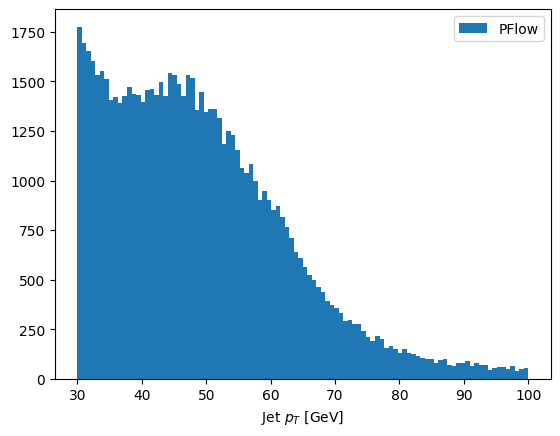

In [4]:
plt.hist(ak.flatten(pflow_jets.pt), label='PFlow', bins=100, range=(30, 100))
plt.legend()
_ = plt.xlabel('Jet $p_T$ [GeV]')

You can change the default calibration configuration if you desire. If your analysis is based on a skim, rather than `DAOD_PHYS`, you might want to do this in some master configuration file that everyone includes.

All queries that occur after the change will use this new default. Note that calibration configuration is captured at run time (when you use `value` or its equivalent), not when you use the `Jets` method, etc. If you find yourself wanting to use multiple configurations in the same script or notebook, modifying the default is almost certainly not the way to do (see below for other more flexible options).

This example modifies the default calibration configuration to use a new jet collection. The identical query above will return a different set of (calibrated) jets:

In [5]:
new_jet_selection = calib_tools.default_config()
new_jet_selection.jet_collection = 'AntiKt4EMTopoJets'
calib_tools.set_default_config(new_jet_selection)

antikt_jets_attempt = (ds
                       .Select(lambda e: e.Jets())
                       .Select(lambda jets: jets.Where(lambda j: (j.pt() / 1000) > 30))
                       .Select(lambda jets: {
                               'pt': [j.pt()/1000.0 for j in jets],
                               'eta': [j.eta() for j in jets],
                               'phi': [j.phi() for j in jets],
                       })
                       .AsAwkwardArray()
                       .value())

And we can see that the PFlow algorithm returns more jets than the anti-kt4 algorithm. And that they are mostly at lower jet $p_T$'s:

In [6]:
len(ak.flatten(pflow_jets.pt)), len(ak.flatten(antikt_jets_attempt.pt))

(74591, 74591)

Wait - they are the same. What is going on here?

The actual reason is one why it is important not to use this feature except under very limited circumstances. If we look at the code that creates this dataset in `config.py`, we'll see:

```python
ds = calib_tools.query_update(ds, perform_overlap_removal=False)
```

That line grabs the default _at the time of the call to `query_update`_ and saves all its values. That occurred during the initial import at the top of the chapter! So us setting this here did nothing! In order to do this, we need to re-run the initial query creation!

In [8]:
# This code is how we make a dataset, from the config.py file.
from config import make_ds, _samples
redone_ds = make_ds(_samples["zee_r24"])

antikt_jets = (redone_ds
               .Select(lambda e: e.Jets())
               .Select(lambda jets: jets.Where(lambda j: (j.pt() / 1000) > 30))
               .Select(lambda jets: {
                       'pt': [j.pt()/1000.0 for j in jets],
                       'eta': [j.eta() for j in jets],
                       'phi': [j.phi() for j in jets],
               })
               .AsAwkwardArray()
               .value())

Found backend type matching "xaod". Matching by type is depreciated. Please switch to using the "name" keyword in your servicex.yaml file.
Found backend type matching "xaod". Matching by type is depreciated. Please switch to using the "name" keyword in your servicex.yaml file.


In [9]:
len(ak.flatten(pflow_jets.pt)), len(ak.flatten(antikt_jets.pt))

(74591, 74591)

Now we see the expected result - two are different. Again - this is a good reason to use other methods than setting the default. All the pitfalls of global variables will hound you!

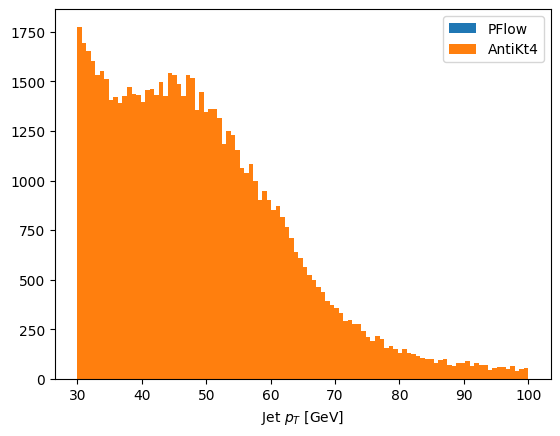

In [10]:
plt.hist(ak.flatten(pflow_jets.pt), label='PFlow', bins=100, range=(30, 100))
plt.hist(ak.flatten(antikt_jets.pt), label='AntiKt4', bins=100, range=(30, 100))
plt.legend()
_ = plt.xlabel('Jet $p_T$ [GeV]')

We can further see that if we find closest-matching jets in $\eta-\phi$, that the algorithms really do gather different amounts of energy (as expected!):

In [11]:
pflow_matched_jets_to_antikt = match_eta_phi(antikt_jets, pflow_jets)

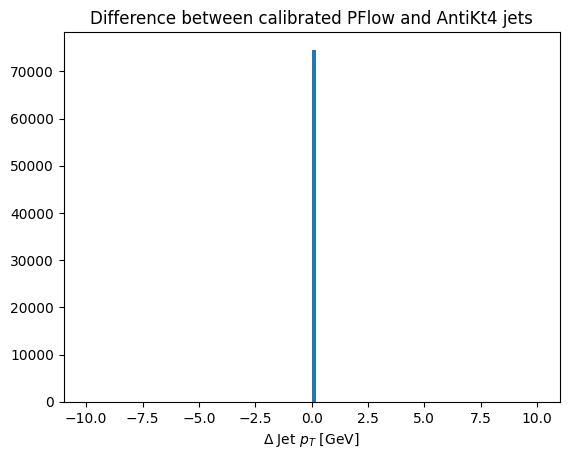

In [12]:
plt.hist(ak.flatten(pflow_matched_jets_to_antikt.pt - antikt_jets.pt), bins=100, range=(-10, 10))
plt.title('Difference between calibrated PFlow and AntiKt4 jets')
_ = plt.xlabel('$\\Delta$ Jet $p_T$ [GeV]')

And then we can use `calib_tools.reset_config()` to reset to factory default. Though this is mostly for test harneses and the like.

In [13]:
calib_tools.reset_config()

```{warning}
The `default_config` is a global variable, so it is fairly dangerous to modify unless you really want to change it for everything.
```

```{warning}
Modifying the `default_collection` is particularly dangerous in a notebook where one can execute cells out of order. If you execute the cell above to get `pflow_jets` after the `antikt_jets` cell, you'll get AntiKt4EMToploJets in your pflow jets!
```

```{admonition} Best practice
Use this technique if you are setting the calibration once for your analysis in central a configuration file. Otherwise, ignore it.
```

## Modifying the calibrated collection in the query

You can modify an aspect of the calibration configuration on a query-by-query basis without using the global `default_config`. There are two ways to do this.

First, you can specify the collection to load in place of the default in the `Jets` (or similar) method. This will alter the collection name and run the full calibration. This is useful for quick tests: it is convinent, and keeps the new bank name close to where you make the request - so it is readable.

In [15]:
# This does not work in R22 b.c. the jets have been so slimmed down.
# jetname_in_query_jets = (ds
#         .Select(lambda e: e.Jets("AntiKt4EMTopoJets"))
#         .Select(lambda jets: jets.Where(lambda j: (j.pt() / 1000) > 30))
#         .Select(lambda jets: {
#                 'pt': [j.pt()/1000.0 for j in jets],
#                 'eta': [j.eta() for j in jets],
#                 'phi': [j.phi() for j in jets],
#         })
#         .AsAwkwardArray()
#         .value())

In [ ]:
# len(ak.flatten(jetname_in_query_jets.pt)), len(ak.flatten(antikt_jets.pt))

In [ ]:
# ak.sum(abs(jetname_in_query_jets.pt - antikt_jets.pt))

However, this doesn't work well if you want to alter more than calibration configuration value.

There is a helper function, `calib_tools.query_update` that allows you to modify values in the calibration configuration. You can also chain the calls, and the modifications will accumulate.

In [ ]:
# config_jets_in_query_jets = (calib_tools.query_update(ds, jet_collection='AntiKt4EMTopoJets')
#         .Select(lambda e: e.Jets())
#         .Select(lambda jets: jets.Where(lambda j: (j.pt() / 1000) > 30))
#         .Select(lambda jets: {
#                 'pt': [j.pt()/1000.0 for j in jets],
#                 'eta': [j.eta() for j in jets],
#                 'phi': [j.phi() for j in jets],
#         })
#         .AsAwkwardArray()
#         .value())

In [ ]:
# ak.sum(abs(config_jets_in_query_jets.pt - antikt_jets.pt))

 Though the code only changes the `jet_collection` you can change as many values in the calibration configuration object as you like in one call. Just add the names as further arguments.

You can even set a whole new configuration if you have lots of changes at once. This will override anything you've previously set with `query_update` in the query.

In [17]:
# config_in_query_jets = (calib_tools.query_update(ds, new_jet_selection, perform_overlap_removal=False)
#         .Select(lambda e: e.Jets())
#         .Select(lambda jets: jets.Where(lambda j: (j.pt() / 1000) > 30))
#         .Select(lambda jets: {
#                 'pt': [j.pt()/1000.0 for j in jets],
#                 'eta': [j.eta() for j in jets],
#                 'phi': [j.phi() for j in jets],
#         })
#         .AsAwkwardArray()
#         .value())

In [ ]:
# ak.sum(abs(config_in_query_jets.pt - antikt_jets.pt))

```{admonition} Best practice

* Use `query_update` for most cases. It has maximum flexibility and composability. In your analysis, where you declare the dataset, you can easily add a call to `calib_tools.query_update`, for example. You can also modify a query on the fly if you need to alter the calibration configuration for some reason.
* Use the `calibrated_collection` argument in a collection request if want to run a one-off test of just a collection change.
* Use the `calib_tools.set_default_config` only if you are going to be using this new configuration for everything that will ever be done, and only if you are sure the configuration file being loaded will always by loaded by everyone in the analysis team.
```

## Systematic Errors

You can only query a single systematic error at a time. You do this by specifying the systematic error you want using the helper method `calib_tools.query_sys_error`. By default, the central value is returned (`NOSYS`). You will need to know the names of the systematic errors a head of time in order to use this.

Here we get jets for evaluated for the systematic error `JET_Pileup_PtTerm_1up`.

In [18]:
sys_jets = (calib_tools.query_sys_error(ds, 'JET_Pileup_PtTerm__1up')
            .Select(lambda e: e.Jets())
            .Select(lambda jets: jets.Where(lambda j: (j.pt() / 1000) > 30))
            .Select(lambda jets: {
                    'pt': [j.pt()/1000.0 for j in jets],
                    'eta': [j.eta() for j in jets],
                    'phi': [j.phi() for j in jets],
            })
            .AsAwkwardArray()
            .value())

And we can compare the values to see how big a correction this is by doing the $\eta-\phi$ matching:

In [19]:
sys_jet_matched = match_eta_phi(pflow_jets, sys_jets)

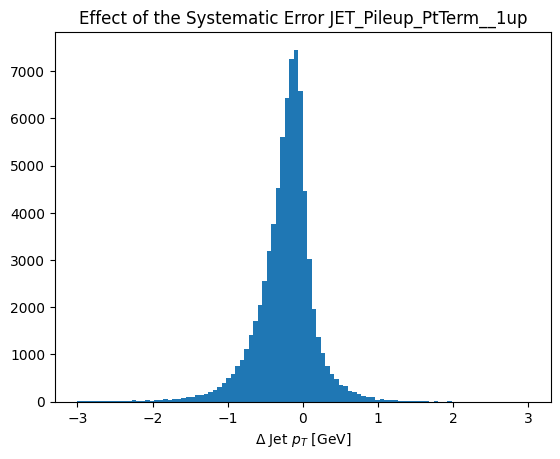

In [20]:
plt.hist(ak.flatten(pflow_jets.pt - sys_jet_matched.pt), bins=100, range=(-3, 3))
plt.title('Effect of the Systematic Error JET_Pileup_PtTerm__1up')
_ = plt.xlabel('$\\Delta$ Jet $p_T$ [GeV]')

While this works, it clearly can't be the final way to do this. Espeically given the push model that ATLAS uses for systematic errors. Thoughts welcome at this [issue on how to implement systematic errors](https://github.com/gordonwatts/xaod_usage/issues/13) in the ATLAS xAOD system for `func_adl`.

## Uncalibrated Collections

You can also request an uncalibrated jet bank - so you can look at the "raw" data. For example, we can compare the overlap and calibrated jets above with the jets in the actual starting bank:

In [21]:
default_jets = calib_tools.default_config().jet_collection
uncalibrated_jets = (ds
        .Select(lambda e: e.Jets(calibrate=False))
        .Select(lambda jets: jets.Where(lambda j: (j.pt() / 1000) > 30))
        .Select(lambda jets: {
                'pt': [j.pt()/1000.0 for j in jets],
                'eta': [j.eta() for j in jets],
                'phi': [j.phi() for j in jets],
        })
        .AsAwkwardArray()
        .value())

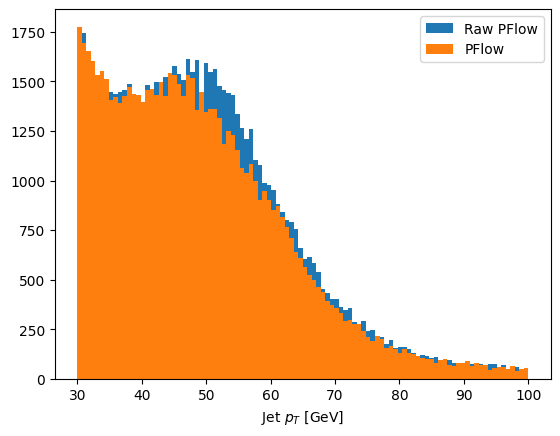

In [22]:
plt.hist(ak.flatten(uncalibrated_jets.pt), label='Raw PFlow', bins=100, range=(30, 100))
plt.hist(ak.flatten(pflow_jets.pt), label='PFlow', bins=100, range=(30, 100))
plt.legend()
_ = plt.xlabel('Jet $p_T$ [GeV]')

In [23]:
uncalibrated_matched = match_eta_phi(pflow_jets, uncalibrated_jets)

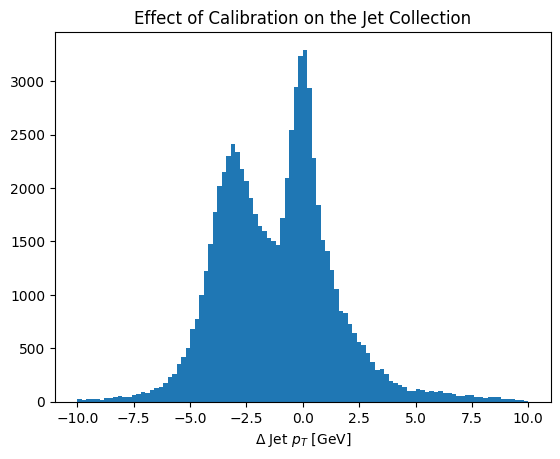

In [24]:
plt.hist(ak.flatten(pflow_jets.pt - uncalibrated_matched.pt), bins=100, range=(-10, 10))
plt.title('Effect of Calibration on the Jet Collection')
_ = plt.xlabel('$\\Delta$ Jet $p_T$ [GeV]')

## AnalysisBase Configuration Code

Everyone familiar with AnalysisBase will recognize that the `func_adl_xAOD` system must at some level configure, via python, the common CP tools. The design of the calibration system here potentially allows you to modify that python code as you wish. However, an API has [not yet been developed](https://github.com/gordonwatts/xaod_usage/issues/14) to do this easily.

If you are curious about exactly what code is being downloaded, feel free to look at the template files located in the `templates` directory in the `func_adl_servicex_xaodr21` package that is installed in your environment.

# Further Information

In [25]:
from func_adl_servicex_xaodr21 import CalibrationEventConfig
help(CalibrationEventConfig)

Help on class CalibrationEventConfig in module func_adl_servicex_xaodr21.calibration_event_config:

class CalibrationEventConfig(builtins.object)
 |  CalibrationEventConfig(jet_collection: str, jet_calib_truth_collection: str, run_jet_ghost_muon_association: bool, electron_collection: str, electron_working_point: str, electron_isolation: str, photon_collection: str, photon_working_point: str, photon_isolation: str, muon_collection: str, muon_working_point: str, muon_isolation: str, tau_collection: str, tau_working_point: str, met_collection: str, perform_overlap_removal: bool, datatype: str, correct_pileup: bool, calibrate: bool, uncalibrated_possible: bool) -> None
 |  
 |  CalibrationEventConfig(jet_collection: str, jet_calib_truth_collection: str, run_jet_ghost_muon_association: bool, electron_collection: str, electron_working_point: str, electron_isolation: str, photon_collection: str, photon_working_point: str, photon_isolation: str, muon_collection: str, muon_working_point: str, 

In [26]:
help(calib_tools)

Help on class calib_tools in module func_adl_servicex_xaodr21.calibration_support:

class calib_tools(builtins.object)
 |  Helper functions to work with a query's calibration configuration.
 |  
 |  Class methods defined here:
 |  
 |  default_config(config_name: Optional[str] = None) -> func_adl_servicex_xaodr21.calibration_event_config.CalibrationEventConfig from builtins.type
 |      Return a copy of the current default calibration configuration.
 |      
 |      If no name is given, then the default data format is returned.
 |      
 |      Args:
 |          config_name (Optional[str], optional): The calibration config name.
 |                      Defaults to None.
 |      
 |      Returns:
 |          CalibrationEventConfig: Config for the requested name (or default one).
 |  
 |  default_sys_error = 'NOSYS'
 |  query_get(query: func_adl.object_stream.ObjectStream[~T]) -> func_adl_servicex_xaodr21.calibration_event_config.CalibrationEventConfig from builtins.type
 |      Return a